# Rescheduling mit Lateness

In [2]:
max_time = 60*60 # 1h

In [3]:
import time

In [4]:
from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 20)

In [5]:
import utils.presenter as show
import utils.checker as check

import utils.schedule_interarrival as sit
import utils.scheduling_solver as ssv

from ProductionDaySimulation import ProductionDaySimulation

In [6]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [7]:
df_instance = pd.read_csv("data/00_instance.csv")
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [8]:
df_ops, df_jobs = rp_init.init_jobs_with_arrivals(df_instance, 2,  u_b_mmax = 0.95)
df_jobs

,Job,Arrival
0,Job_000,0.00
1,Job_001,83.42
2,Job_002,144.74
3,Job_003,197.03
4,Job_004,233.63
...,...,...
33,Job_033,2568.21
34,Job_034,2574.27
35,Job_035,2575.63
36,Job_036,2694.35


In [9]:
# a) Initialisierung der Deadlines
df_jobs = deadline_gen.get_times_df(df_ops, df_jobs, ssv.schedule_fcfs_with_arrivals, target_service=1.0)

# Rundung für CP 
df_jobs["Arrival"] = np.floor(df_jobs["Arrival"]).astype(int)
df_jobs["Deadline"] = np.ceil(df_jobs["Deadline"]).astype(int)
df_jobs.head()

,Job,Arrival,Deadline
0,Job_000,0,1042
1,Job_001,83,1428
2,Job_002,144,1642
3,Job_003,197,1924
4,Job_004,233,1270


In [10]:
# b) Bestimmung der "Ready Time"
df_jobs['Ready Time'] = ((df_jobs['Arrival'] // 1440) + 1) * 1440

# c) Processing Time
processing_time = df_ops.groupby('Job')['Processing Time'].sum()
df_jobs = pd.merge(df_jobs, processing_time, on='Job')

# d) Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])

# e) Anpassung der Deadlines
min_slack = df_jobs['Slack'].min()

if min_slack < 0:
    df_jobs["Deadline"] = df_jobs["Deadline"] + abs(min_slack)
df_jobs

# f) erneute Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])
df_jobs 

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1835,1440,395,0
1,Job_001,83,2221,1440,510,271
2,Job_002,144,2435,1440,568,427
3,Job_003,197,2717,1440,655,622
4,Job_004,233,2063,1440,393,230
...,...,...,...,...,...,...
33,Job_033,2568,5088,2880,655,1553
34,Job_034,2574,4404,2880,393,1131
35,Job_035,2575,4866,2880,568,1418
36,Job_036,2694,4529,2880,395,1254


In [11]:
day_length = 1440

## I) Tag 1

In [13]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [14]:
def filter_ops_and_jobs_by_ready_time(df_jobs: pd.DataFrame, df_ops: pd.DataFrame, 
                              ready_time_col = "Ready Time", ready_time: int = 0) -> tuple[pd.DataFrame, pd.DataFrame]:

    # Jobs zeitlich filtern
    time_filter = df_jobs[ready_time_col] == ready_time
    df_jobs_filtered = df_jobs[time_filter].copy()

    # Operationen nach (gefilterten) Jobs filtern
    jobs = df_jobs_filtered["Job"]
    df_ops_filtered = df_ops[df_ops["Job"].isin(jobs)].copy()
    return df_jobs_filtered, df_ops_filtered

In [15]:
df_jobs_curr, df_ops_curr = filter_ops_and_jobs_by_ready_time(df_jobs, df_ops, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1835,1440,395,0
1,Job_001,83,2221,1440,510,271
2,Job_002,144,2435,1440,568,427
3,Job_003,197,2717,1440,655,622
4,Job_004,233,2063,1440,393,230
5,Job_005,302,2404,1440,496,468
6,Job_006,340,2231,1440,416,375
7,Job_007,488,2703,1440,539,724
8,Job_008,708,3076,1440,597,1039
9,Job_009,740,2958,1440,540,978


### A) Scheduling für Tag 1

In [17]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_cp_jssp_lateness_by_tardiness_and_earliness(df_ops_curr, df_jobs_curr, w_t = 5,
                                                                schedule_start = 1440,
                                                                msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Objective Value       : 17.00
Best Objective Bound  : 17.00
Laufzeit              : 0.13 Sekunden

Scheduling-Dauer: 0 Minuten und 0.15 Sekunden.


,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,1835,1440,29,1469,-366,0,366
1,Job_005,0,M2,302,2404,1440,84,1524,-880,0,880
2,Job_000,1,M1,0,1835,1469,78,1547,-288,0,288
3,Job_017,0,M0,1254,3089,1469,29,1498,-1591,0,1591
4,Job_001,0,M0,83,2221,1498,43,1541,-680,0,680
...,...,...,...,...,...,...,...,...,...,...,...
185,Job_011,9,M8,894,3262,3188,74,3262,0,0,0
186,Job_013,9,M7,1123,3224,3199,25,3224,0,0,0
187,Job_016,9,M4,1135,3426,3393,33,3426,0,0,0
188,Job_018,9,M7,1354,3571,3526,45,3571,0,0,0


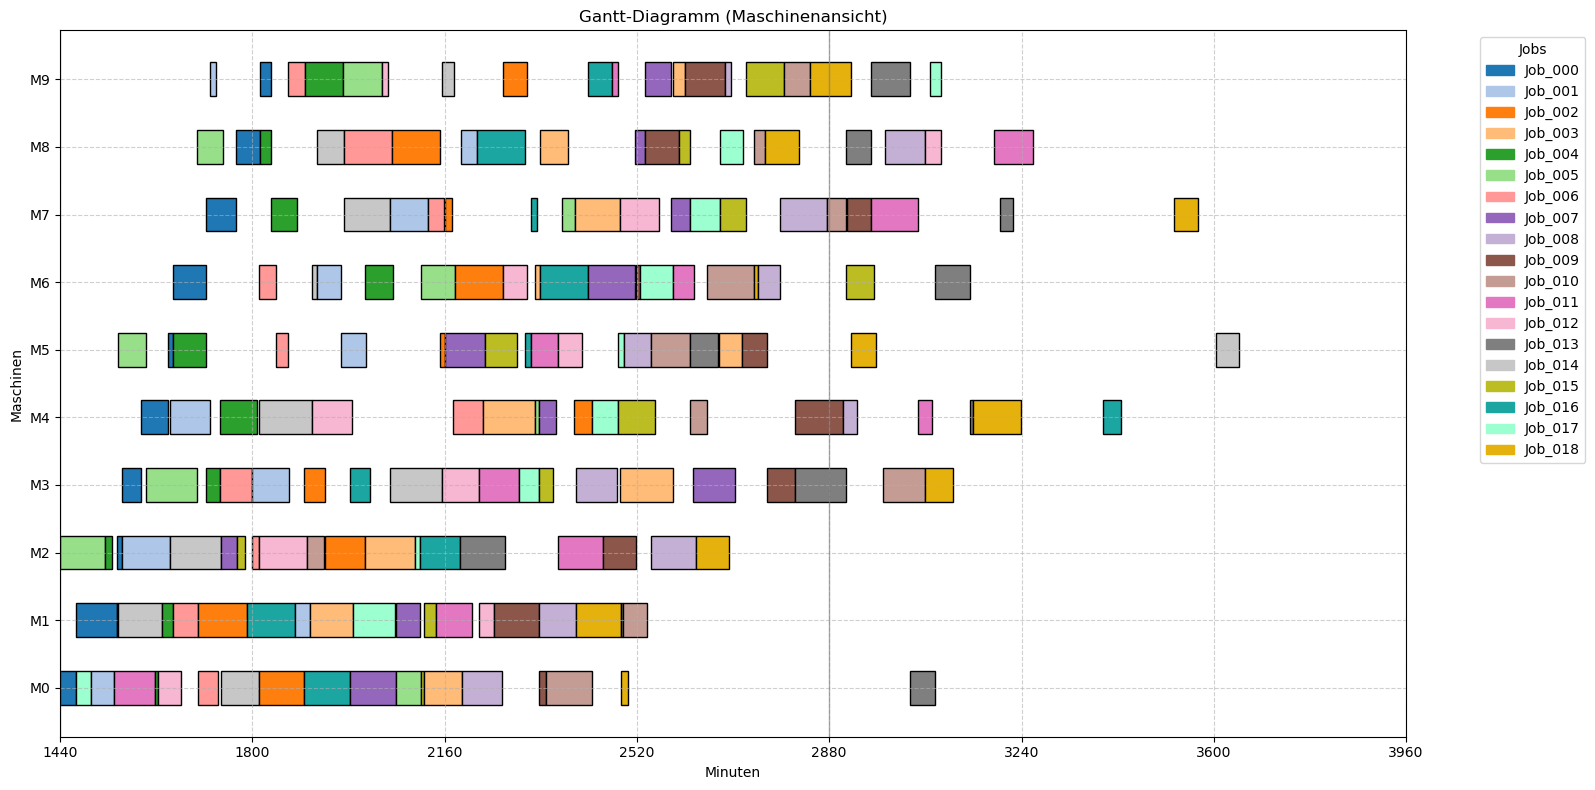

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [18]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

### B) Aufteilung in heutige und zukünftge Operationen

In [20]:
def filter_plan_for_today(df_plan, latest_op_start: int = 0): # exclusive
    filt = (df_plan.Start < latest_op_start)
    return df_plan[filt].sort_values(by="Job").reset_index(drop=True)

In [21]:
df_plan_for_sim = filter_plan_for_today(df_plan, latest_op_start = day_end)
df_plan_for_sim

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,1835,1440,29,1469,-366,0,366
1,Job_000,9,M9,0,1835,1814,21,1835,0,0,0
2,Job_000,1,M1,0,1835,1469,78,1547,-288,0,288
3,Job_000,8,M8,0,1835,1770,44,1814,-21,0,21
4,Job_000,7,M7,0,1835,1714,56,1770,-65,0,65
...,...,...,...,...,...,...,...,...,...,...,...
163,Job_018,2,M2,1354,3571,2631,61,2692,-879,0,879
164,Job_018,4,M8,1354,3571,2759,64,2823,-748,0,748
165,Job_018,1,M0,1354,3571,2491,13,2504,-1067,0,1067
166,Job_018,5,M9,1354,3571,2844,76,2920,-651,0,651


In [22]:
def filter_plan_for_future(df_plan, earliest_op_start: int = 0):
    filt = (df_plan.Start >= earliest_op_start)
    return df_plan[filt].sort_values(by=["Job", "Start"]).reset_index(drop=True)

In [23]:
df_plan_waiting = filter_plan_for_future(df_plan, earliest_op_start = day_end)
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_008,8,M4,708,3076,2906,26,2932,-144,0,144
1,Job_008,9,M8,708,3076,2985,74,3059,-17,0,17
2,Job_009,9,M7,740,2958,2913,45,2958,0,0,0
3,Job_010,9,M3,845,3059,2980,79,3059,0,0,0
4,Job_011,7,M7,894,3262,2958,89,3047,-215,0,215
...,...,...,...,...,...,...,...,...,...,...,...
17,Job_017,9,M9,1254,3089,3068,21,3089,0,0,0
18,Job_018,6,M5,1354,3571,2920,47,2967,-604,0,604
19,Job_018,7,M3,1354,3571,3059,52,3111,-460,0,460
20,Job_018,8,M4,1354,3571,3149,90,3239,-332,0,332


### C) Simulation

In [25]:
simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.3)
df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job_000 started on M0
[24:00:00] Job_005 started on M2
[24:14:46] Job_000 finished on M0 (after 14 minutes 47 seconds)
[24:29:00] Job_017 started on M0
[24:29:00] Job_000 started on M1
[24:54:06] Job_017 finished on M0 (after 25 minutes 07 seconds)
[24:58:00] Job_001 started on M0
[25:28:05] Job_005 finished on M2 (after 88 minutes 06 seconds)
[25:28:05] Job_004 started on M2
[25:34:20] Job_001 finished on M0 (after 36 minutes 20 seconds)
[25:41:00] Job_011 started on M0
[25:46:25] Job_004 finished on M2 (after 18 minutes 20 seconds)
[25:56:00] Job_001 started on M2
[26:11:27] Job_000 finished on M1 (after 102 minutes 28 seconds)
[26:11:27] Job_005 started on M1
[26:13:13] Job_005 finished on M1 (after 01 minute 46 seconds)
[26:13:13] Job_014 started on M1
[26:13:13] Job_005 started on M5
[27:27:14] Job_011 finished on M0 (after 106 minutes 14 seconds)
[27:27:14] Job_004 started on M0
[27:32:20] Job_004 finished on M0 (after 05 minutes 06 seconds)
[27:32:20] Job_012 started 

In [26]:
df_plan_undone

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
87,Job_008,4,M2,708,3076,2546,85,2631,-445,0,445
84,Job_008,5,M9,708,3076,2685,11,2696,-380,0,380
85,Job_008,6,M6,708,3076,2747,40,2787,-289,0,289
80,Job_008,7,M7,708,3076,2787,89,2876,-200,0,200
88,Job_009,6,M5,740,2958,2717,47,2764,-194,0,194
93,Job_009,7,M3,740,2958,2764,52,2816,-142,0,142
91,Job_009,8,M4,740,2958,2816,90,2906,-52,0,52
100,Job_010,6,M8,845,3059,2740,19,2759,-300,0,300
97,Job_010,7,M9,845,3059,2796,48,2844,-215,0,215
104,Job_010,8,M7,845,3059,2876,36,2912,-147,0,147


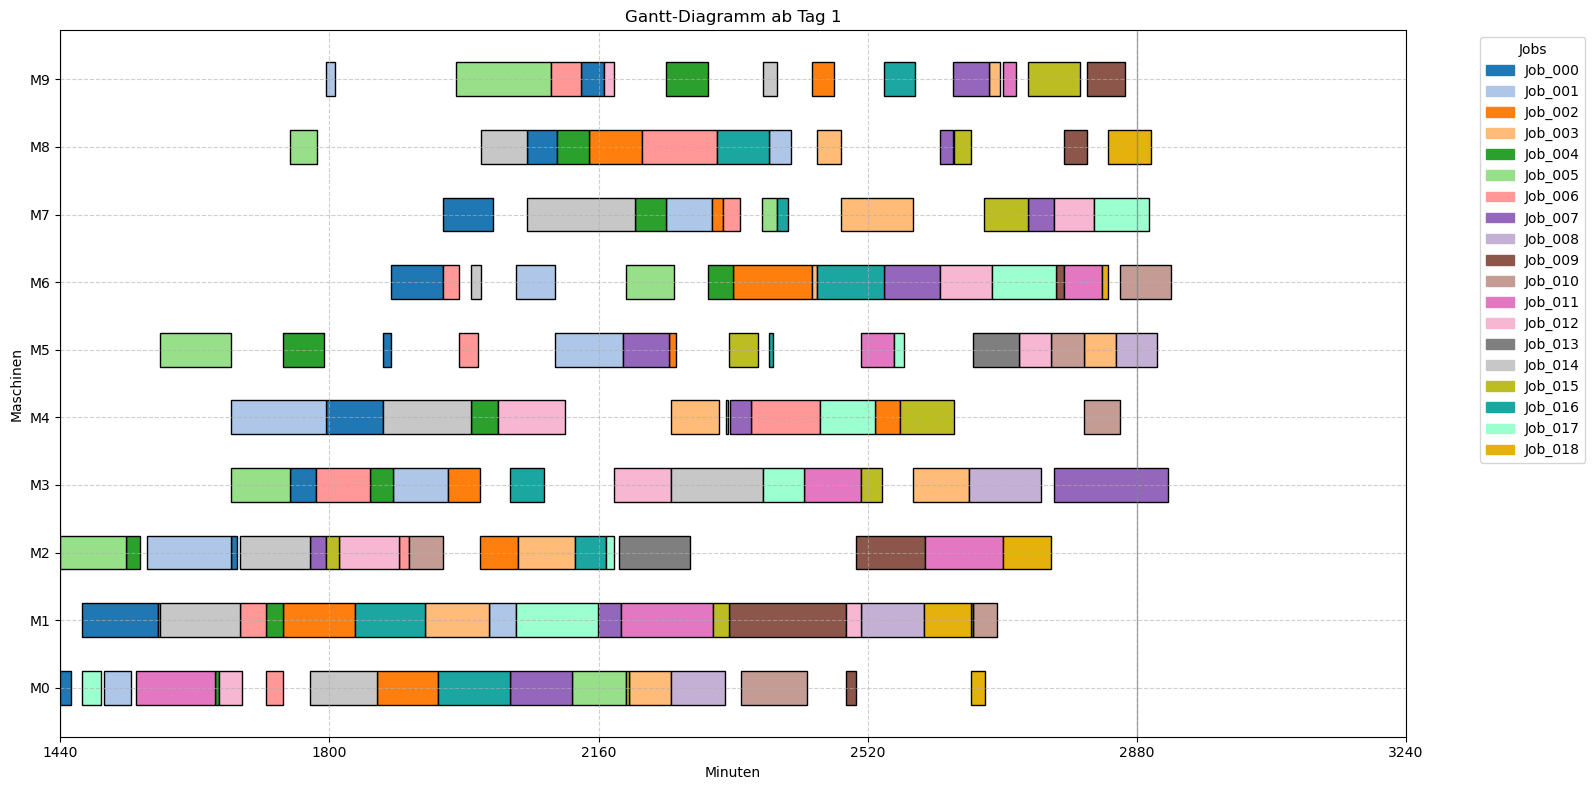

In [27]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [28]:
df_execution

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,0,0,M0,1440.00,14.78,1454.78,1454.78
1,Job_000,1,0,M1,1469.00,102.46,1571.46,1571.46
2,Job_000,2,0,M2,1668.65,7.20,1675.85,1675.85
3,Job_000,3,0,M3,1747.96,34.00,1781.96,1781.96
4,Job_000,4,0,M4,1795.89,76.55,1872.44,1872.44
...,...,...,...,...,...,...,...,...
150,Job_018,0,1354,M1,2594.68,63.64,1304.32,2658.32
151,Job_018,1,1354,M0,2658.32,18.53,1322.85,2676.85
152,Job_018,2,1354,M2,2700.76,64.40,1411.16,2765.16
153,Job_018,3,1354,M6,2833.08,7.70,1486.78,2840.78


## II) Tag 2
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [30]:
day_numb = 2

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


#### a) Filtern nach der aktuellen "Ready Time"

In [32]:
df_jobs_curr, df_ops_curr = filter_ops_and_jobs_by_ready_time(df_jobs, df_ops, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
19,Job_019,1440,3275,2880,395,0
20,Job_020,1523,3661,2880,510,271
21,Job_021,1584,3875,2880,568,427
22,Job_022,1637,4157,2880,655,622
23,Job_023,1673,3503,2880,393,230
24,Job_024,1742,3844,2880,496,468
25,Job_025,1780,3671,2880,416,375
26,Job_026,1928,4143,2880,539,724
27,Job_027,2148,4516,2880,597,1039
28,Job_028,2180,4398,2880,540,978


### b) Operationen, die zuvor "ready" waren, aber noch nicht starten sollten

In [34]:
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_008,8,M4,708,3076,2906,26,2932,-144,0,144
1,Job_008,9,M8,708,3076,2985,74,3059,-17,0,17
2,Job_009,9,M7,740,2958,2913,45,2958,0,0,0
3,Job_010,9,M3,845,3059,2980,79,3059,0,0,0
4,Job_011,7,M7,894,3262,2958,89,3047,-215,0,215
...,...,...,...,...,...,...,...,...,...,...,...
17,Job_017,9,M9,1254,3089,3068,21,3089,0,0,0
18,Job_018,6,M5,1354,3571,2920,47,2967,-604,0,604
19,Job_018,7,M3,1354,3571,3059,52,3111,-460,0,460
20,Job_018,8,M4,1354,3571,3149,90,3239,-332,0,332


In [35]:
# Sicherstellen, dass beide DataFrames die Spalten 'Job' und 'Operation' haben
df_ops_waiting = df_ops.merge(df_plan_waiting[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_ops_waiting

,Job,Operation,Machine,Processing Time
0,Job_008,8,M4,26
1,Job_008,9,M8,74
2,Job_009,9,M7,45
3,Job_010,9,M3,79
4,Job_011,7,M7,89
...,...,...,...,...
17,Job_017,9,M9,21
18,Job_018,6,M5,47
19,Job_018,7,M3,52
20,Job_018,8,M4,90


In [36]:
df_jobs_waiting = df_jobs[df_jobs["Job"].isin(df_plan_waiting["Job"].unique())]
df_jobs_waiting

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
8,Job_008,708,3076,1440,597,1039
9,Job_009,740,2958,1440,540,978
10,Job_010,845,3059,1440,539,1080
11,Job_011,894,3262,1440,597,1225
12,Job_012,950,3089,1440,510,1139
13,Job_013,1123,3224,1440,496,1288
14,Job_014,1128,3648,1440,655,1553
15,Job_015,1134,2964,1440,393,1131
16,Job_016,1135,3426,1440,568,1418
17,Job_017,1254,3089,1440,395,1254


#### c) Unerledigte Operationen

In [38]:
df_plan_undone

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
87,Job_008,4,M2,708,3076,2546,85,2631,-445,0,445
84,Job_008,5,M9,708,3076,2685,11,2696,-380,0,380
85,Job_008,6,M6,708,3076,2747,40,2787,-289,0,289
80,Job_008,7,M7,708,3076,2787,89,2876,-200,0,200
88,Job_009,6,M5,740,2958,2717,47,2764,-194,0,194
93,Job_009,7,M3,740,2958,2764,52,2816,-142,0,142
91,Job_009,8,M4,740,2958,2816,90,2906,-52,0,52
100,Job_010,6,M8,845,3059,2740,19,2759,-300,0,300
97,Job_010,7,M9,845,3059,2796,48,2844,-215,0,215
104,Job_010,8,M7,845,3059,2876,36,2912,-147,0,147


In [39]:
# Sicherstellen, dass beide DataFrames die Spalten 'Job' und 'Operation' haben
df_ops_undone = df_ops.merge(df_plan_undone[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_ops_undone

,Job,Operation,Machine,Processing Time
0,Job_008,4,M2,85
1,Job_008,5,M9,11
2,Job_008,6,M6,40
3,Job_008,7,M7,89
4,Job_009,6,M5,47
5,Job_009,7,M3,52
6,Job_009,8,M4,90
7,Job_010,6,M8,19
8,Job_010,7,M9,48
9,Job_010,8,M7,36


In [40]:
df_jobs_undone = df_jobs[df_jobs["Job"].isin(df_ops_undone["Job"].unique())]
df_jobs_undone

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
8,Job_008,708,3076,1440,597,1039
9,Job_009,740,2958,1440,540,978
10,Job_010,845,3059,1440,539,1080
13,Job_013,1123,3224,1440,496,1288
17,Job_017,1254,3089,1440,395,1254
18,Job_018,1354,3571,1440,540,1591


### Zusammenführen

In [103]:
# Operationen
df_ops_curr_all = pd.concat([df_ops_curr, df_ops_waiting, df_ops_undone], ignore_index=True)
df_ops_curr_all = df_ops_curr_all.sort_values(by=["Job", "Operation"]).reset_index(drop=True)
df_ops_curr_all

,Job,Operation,Machine,Processing Time
0,Job_008,4,M2,85
1,Job_008,5,M9,11
2,Job_008,6,M6,40
3,Job_008,7,M7,89
4,Job_008,8,M4,26
...,...,...,...,...
220,Job_037,5,M9,76
221,Job_037,6,M5,47
222,Job_037,7,M3,52
223,Job_037,8,M4,90


In [43]:
df_jobs_curr_all = pd.concat([df_jobs_curr, df_jobs_waiting, df_jobs_undone], ignore_index=True)
df_jobs_curr_all = df_jobs_curr_all.drop_duplicates(subset="Job", keep="first").sort_values(by="Job").reset_index(drop=True)
df_jobs_curr_all

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_008,708,3076,1440,597,1039
1,Job_009,740,2958,1440,540,978
2,Job_010,845,3059,1440,539,1080
3,Job_011,894,3262,1440,597,1225
4,Job_012,950,3089,1440,510,1139
...,...,...,...,...,...,...
25,Job_033,2568,5088,2880,655,1553
26,Job_034,2574,4404,2880,393,1131
27,Job_035,2575,4866,2880,568,1418
28,Job_036,2694,4529,2880,395,1254


### Prev. Plan 

In [45]:
df_plan_prev = pd.concat([df_plan_waiting, df_plan_undone]).sort_values(by=["Job", "Start"]).reset_index(drop=True)
df_plan_prev

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_008,4,M2,708,3076,2546,85,2631,-445,0,445
1,Job_008,5,M9,708,3076,2685,11,2696,-380,0,380
2,Job_008,6,M6,708,3076,2747,40,2787,-289,0,289
3,Job_008,7,M7,708,3076,2787,89,2876,-200,0,200
4,Job_008,8,M4,708,3076,2906,26,2932,-144,0,144
...,...,...,...,...,...,...,...,...,...,...,...
30,Job_018,5,M9,1354,3571,2844,76,2920,-651,0,651
31,Job_018,6,M5,1354,3571,2920,47,2967,-604,0,604
32,Job_018,7,M3,1354,3571,3059,52,3111,-460,0,460
33,Job_018,8,M4,1354,3571,3149,90,3239,-332,0,332


### A) Rescheduling für Tag 2

In [47]:
# Reduktion der bereits ausgeführten Operationen, die im heutigen Plan hineinlaufen
df_execution_important = df_execution[df_execution["End"] >= day_start]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
79,Job_007,9,488,M3,2769.77,152.15,2433.92,2921.92
83,Job_008,3,708,M5,2852.31,54.06,2198.37,2906.37
95,Job_010,5,845,M6,2856.83,68.70,2080.53,2925.53
149,Job_017,7,1254,M7,2822.99,73.21,1642.20,2896.20
154,Job_018,4,1354,M8,2840.78,58.58,1545.36,2899.36


In [48]:
def solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    df_executed: pd.DataFrame,
    df_original_plan: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    r: float = 0.5,
    reschedule_start: float = 1440.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    """
    Solves a Job-Shop Scheduling Problem using Constraint Programming with:
    - weighted tardiness,
    - earliness,
    - deviation penalty from a given reference plan (df_original_plan).

    Only deviations for operations present in both df_jssp and df_original_plan are considered.

    Parameters:
        df_jssp: Job-Shop structure with ['Job','Operation','Machine','Processing Time']
        df_arrivals_deadlines: Arrival and Deadline info per Job
        df_executed: Already executed operations
        df_original_plan: Reference plan with original start times
        w_t, w_e: Weights for tardiness and earliness
        r: Relative weight between lateness and deviation (0–1)
        reschedule_start: Planning starts from this time onward
        sort_ascending: Sort jobs by deadline ascending (default: False)
        msg: Verbose solver output
        timeLimit: Max solver time in seconds
        gapRel: Relative gap limit

    Returns:
        df_schedule: A DataFrame with scheduled operations and timing info
    """

    model = cp_model.CpModel()
    w_t = int(w_t)
    w_e = int(w_e)
    r_scaled = int(round(r * 100))  # scaled for integer arithmetic

    # === Vorbereitung: Ankunft, Deadline, Jobliste ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Relevante Deviation-Paare bestimmen ===
    deviation_relevant_ops = set(
        df_jssp[["Job", "Operation"]].apply(tuple, axis=1)
    ) & set(
        df_original_plan[["Job", "Operation"]].apply(tuple, axis=1)
    )

    original_start = {
        (row["Job"], row["Operation"]): int(round(row["Start"]))
        for _, row in df_original_plan.iterrows()
        if (row["Job"], row["Operation"]) in deviation_relevant_ops
    }

    # === Operationen strukturieren ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Planungshorizont abschätzen ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Fixierte Operationen berücksichtigen ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }
    last_executed_end = df_executed.groupby("Job")["End"].max().to_dict()

    # === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []
    deviation_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Constraints und Zielterme ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = End - Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Startzeitbedingungen
        model.Add(starts[(j, 0)] >= max(arrival[job], int(reschedule_start)))
        if job in last_executed_end:
            model.Add(starts[(j, 0)] >= int(math.ceil(last_executed_end[job])))

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

        # Deviation: nur für relevante Ops
        for o, (op_id, _, _) in enumerate(all_ops[j]):
            key = (job, op_id)
            if key in original_start:
                dev = model.NewIntVar(0, horizon, f"dev_{j}_{o}")
                diff = model.NewIntVar(-horizon, horizon, f"diff_{j}_{o}")
                model.Add(diff == starts[(j, o)] - original_start[key])
                model.AddAbsEquality(dev, diff)
                deviation_terms.append(dev)

    # === Maschinenrestriktionen (inkl. fixierter Intervalle) ===
    for m in machines:
        machine_intervals = [interval for (j, o), (interval, mach) in intervals.items() if mach == m]
        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            duration = end - start
            if duration > 0:
                fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
                machine_intervals.append(fixed_interval)
        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion kombinieren ===
    weighted_part = model.NewIntVar(0, horizon * len(weighted_terms), "weighted_part")
    deviation_part = model.NewIntVar(0, horizon * len(deviation_terms), "deviation_part")
    model.Add(weighted_part == sum(weighted_terms))
    model.Add(deviation_part == sum(deviation_terms))

    total_cost = model.NewIntVar(0, horizon * len(jobs) * 100, "total_cost")
    model.Add(total_cost == r_scaled * weighted_part + (100 - r_scaled) * deviation_part)
    model.Minimize(total_cost)

    # === Solver-Einstellungen ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.max_time_in_seconds = timeLimit
    solver.parameters.relative_gap_limit = gapRel
    status = solver.Solve(model)

    # === Ergebnis extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")
    print(f"Deviation terms       : {len(deviation_terms)}")

    return df_schedule

In [49]:
starting_time = time.time()

df_reschedule = solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(df_ops_curr_all, df_jobs_curr_all, 
                                                                              df_execution_important,
                                                                              df_original_plan = df_plan_prev,
                                                                              w_t = 5,
                                                                              r = 0.70, # 70% Lateness, 30% Deviation
                                                                              reschedule_start = day_start,
                                                                              msg=False, timeLimit=max_time, gapRel= 0.01)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_reschedule


Solver-Status         : OPTIMAL
Objective Value       : 474940.00
Best Objective Bound  : 474940.00
Laufzeit              : 1093.29 Sekunden
Deviation terms       : 35

Scheduling-Dauer: 18 Minuten und 13.34 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_019,0,1440,3275,M0,2880,29,2909,-366,0,366
1,Job_021,0,1584,3875,M1,2880,91,2971,-904,0,904
2,Job_023,0,1673,3503,M2,2880,14,2894,-609,0,609
3,Job_008,4,708,3076,M2,2907,85,2992,-84,0,84
4,Job_009,6,740,2958,M5,2907,47,2954,-4,0,4
...,...,...,...,...,...,...,...,...,...,...,...
220,Job_030,9,2334,4702,M8,4628,74,4702,0,0,0
221,Job_032,9,2563,4664,M7,4639,25,4664,0,0,0
222,Job_035,9,2575,4866,M4,4833,33,4866,0,0,0
223,Job_037,9,2794,5011,M7,4966,45,5011,0,0,0


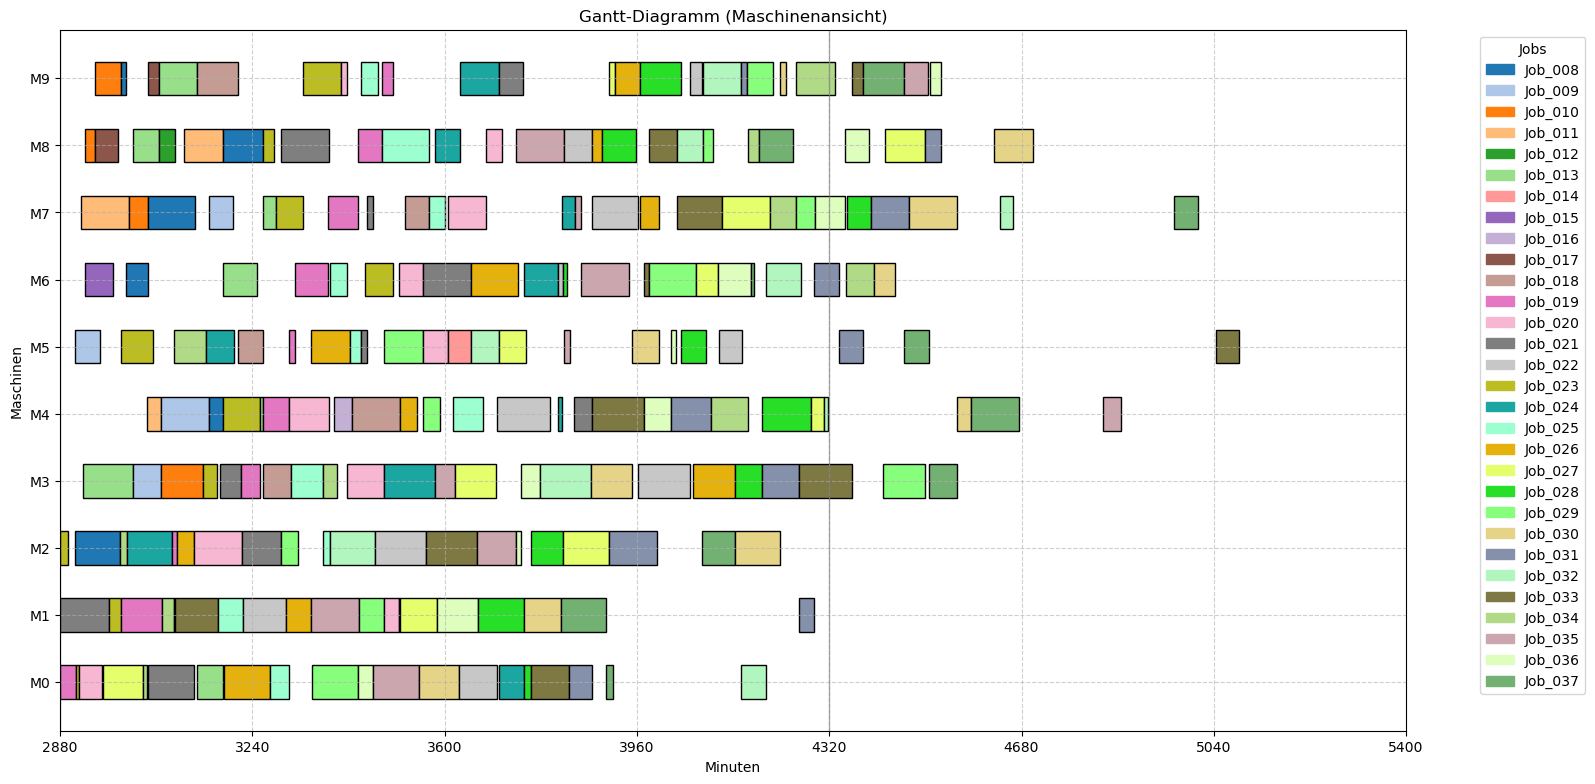

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [50]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

In [51]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60)

label
<-180           0
-180 - -120     0
-120 - -60      1
-60 - 0         2
0              18
0 - 60          4
60 - 120        2
120 - 180       0
>180            3
Name: count, dtype: int32

In [52]:
 df_execution[df_execution.Job == "Job_011"]

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
96,Job_011,0,894,M0,1541.00,106.24,753.24,1647.24
97,Job_011,1,894,M1,2190.18,123.54,1419.72,2313.72
98,Job_011,2,894,M3,2435.46,75.91,1617.37,2511.37
99,Job_011,3,894,M5,2511.37,44.43,1661.80,2555.80
100,Job_011,4,894,M2,2596.88,103.88,1806.76,2700.76
101,Job_011,5,894,M9,2700.76,18.21,1824.97,2718.97
102,Job_011,6,894,M6,2781.89,51.19,1939.08,2833.08


In [53]:
df_reschedule[df_reschedule.Job == "Job_011"]

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
7,Job_011,7,894,3262,M7,2919,89,3008,-254,0,254
25,Job_011,8,894,3262,M4,3043,26,3069,-193,0,193
39,Job_011,9,894,3262,M8,3111,74,3185,-77,0,77


### Combi aus Simulation und Neuplannung

In [55]:
# Relevante Spalten
columns_needed = ["Job", "Operation", "Arrival", "Machine", "Start", "Processing Time", "End"]

# Spalte in df_execution umbenennen
df_execution_important_renamed = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})

# Auf die gewünschten Spalten beschränken
df_exec_trimmed = df_execution_important_renamed[columns_needed]
df_resched_trimmed = df_reschedule[columns_needed]

# DataFrames zusammenführen
df_combined = pd.concat([df_exec_trimmed, df_resched_trimmed], ignore_index=True)
df_combined

,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,Job_000,0,0,M0,1440.00,14.78,1454.78
1,Job_000,1,0,M1,1469.00,102.46,1571.46
2,Job_000,2,0,M2,1668.65,7.20,1675.85
3,Job_000,3,0,M3,1747.96,34.00,1781.96
4,Job_000,4,0,M4,1795.89,76.55,1872.44
...,...,...,...,...,...,...,...
375,Job_030,9,2334,M8,4628.00,74.00,4702.00
376,Job_032,9,2563,M7,4639.00,25.00,4664.00
377,Job_035,9,2575,M4,4833.00,33.00,4866.00
378,Job_037,9,2794,M7,4966.00,45.00,5011.00


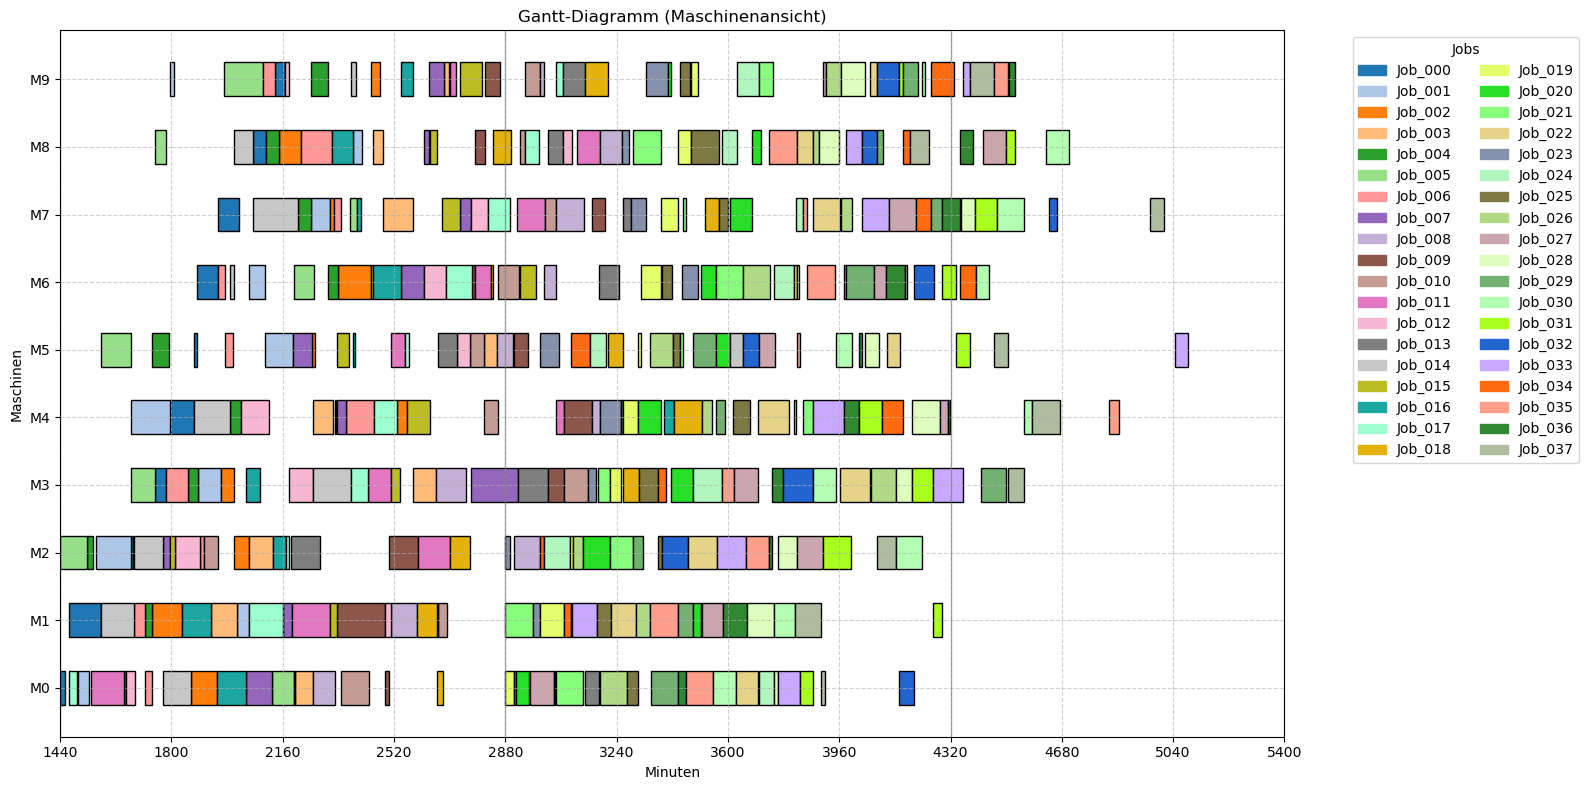

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [56]:
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)